
# Word Representations in NLP

We'll have a look at the most important concepts in chronological order

1. **Bag of Words (BoW)** (statistical)
2. **TF–IDF** (statistical)
3. **N-grams** (statistical)
4. **Latent Semantic Analysis (LSA)** (statistical)
5. **Word2Vec** (simple neural network)
6. **GloVe** (simple neural network)
7. **ELMo** (LSTM)
8. **BERT**(transformer)




## A. Setup & Imports

In [ ]:
# # installs
# %%capture
# !pip install gensim
# !pip install flair
# !pip install numpy==1.24.3

In [2]:
# imports
import math
import random
import itertools
import collections
import requests
import re
import nltk
from gensim.models import Word2Vec


# numerics and plotting
import numpy as np
import matplotlib.pyplot as plt

# sklearn stuff
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# gensim
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
glove_pre = api.load("glove-wiki-gigaword-100")


# random seed for reproducibility
random.seed(42)
np.random.seed(42)

# matplotlib defaults
plt.rcParams.update({
    "figure.figsize": (7, 5),
    "axes.grid": True
})

nltk.download("punkt")

[==================================================] 100.0% 128.1/128.1MB downloaded


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laran\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True


## B. Small Demo Corpus


In [4]:

corpus = [
    "John likes to watch movies and eat popcorn",
    "Mary likes movies too and enjoys film festivals",
    "Many pets like cats and dogs and play with toys",
    "Dogs and cats are common pets and loyal companions",
    "He went to the bank to deposit money",
    "The bank of the river was steep and rocky",
    "They played football games at the stadium",
    "The team enjoys playing football every weekend",
    "The king and the queen live in a palace",
    "The prince is the son of the king and the queen"
]

# also keep tokenized versions for some sections
tokenized_corpus = [doc.lower().split() for doc in corpus]

print("Documents:", len(corpus))
for i, d in enumerate(corpus[:3]):
    print(f"Doc {i}: {d}")

tokenized_corpus = [doc.lower().split() for doc in corpus]


Documents: 10
Doc 0: John likes to watch movies and eat popcorn
Doc 1: Mary likes movies too and enjoys film festivals
Doc 2: Many pets like cats and dogs and play with toys


## C. Bram Stoker's Dracula

let's throw some "real" text in the mix.

In [6]:
import requests
import re
import nltk
nltk.download('punkt_tab')

# Fetch Dracula from Project Gutenberg
url = "https://gutenberg.org/cache/epub/345/pg345.txt"
response = requests.get(url)
raw_text = response.text

# split into sentences
sentences = nltk.sent_tokenize(raw_text)

# clean up whitespace
sentences = [re.sub(r"\s+", " ", s).strip() for s in sentences]

# skip first 100 sentences, then take next 1000
corpus2 = sentences[100:1100]

print(f"Total sentences extracted: {len(sentences)}")
print(f"Subset size: {len(corpus2)}")
# print random 5 sentences for sanity check

drac_sample = random.sample(corpus2, 5)
print("Sample sentences from Dracula", "\n", (drac_sample))


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\laran\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


Total sentences extracted: 7499
Subset size: 1000
Sample sentences from Dracula 
 ['I sat and pondered awhile, and then some thought occurred to me, and I made search of my portmanteau and in the wardrobe where I had placed my clothes.', 'I think I must have fallen asleep and kept dreaming of the incident, for it seemed to be repeated endlessly, and now looking back, it is like a sort of awful nightmare.', 'I soon lost sight and recollection of ghostly fears in the beauty of the scene as we drove along, although had I known the language, or rather languages, which my fellow-passengers were speaking, I might not have been able to throw them off so easily.', 'Then I went over every inch of the ground, so as not to lose a chance.', 'So!” We went thoroughly into the business of the purchase of the estate at Purfleet.']


## 1. Bag of Words (BoW)

**Core idea**: represent each document as a vector of word counts; order is ignored.

**Why it matters**: First practical way to feed text into M. simple, fast,  strong baselines.

**Strengths**: Simple, easy to interpret; works well with linear models

**Limits**: No word order, no semantics (synonyms/polysemy), very high-dimensional/sparse.

**Use cases**: Quick baselines for classification/retrieval


In [7]:

# create BoW matrix
bow_vectorizer = CountVectorizer(lowercase=True)
X_bow = bow_vectorizer.fit_transform(corpus)
vocab = bow_vectorizer.get_feature_names_out()

print("Vocab size:", len(vocab))
print("First 20 vocab terms:", vocab[:20])

# convert to dense for visualization (OK on tiny corpus)
bow_dense = X_bow.toarray()

Vocab size: 54
First 20 vocab terms: ['and' 'are' 'at' 'bank' 'cats' 'common' 'companions' 'deposit' 'dogs'
 'eat' 'enjoys' 'every' 'festivals' 'film' 'football' 'games' 'he' 'in'
 'is' 'john']



## 2. TF–IDF

**Core idea**: Reweight BoW by term rarity: tfidf(t,d) = tf(t,d) * log(N / df(t)).

**Why it matters**: Emphasizes informative words; became standard in search and text mining.

**Strengths**: Robust, strong with linear models; downweights stopwords automatically.

**Limit**: Still context-agnostic; synonyms remain separate; no sequence info.

Use cases: ranking, topic hints, baseline classifiers.


In [8]:

tfidf_vectorizer = TfidfVectorizer(lowercase=True)
X_tfidf = tfidf_vectorizer.fit_transform(corpus)
vocab_tfidf = tfidf_vectorizer.get_feature_names_out()
tfidf_dense = X_tfidf.toarray()


# Show top TF–IDF terms per document
def top_tfidf_terms(row, vocab, k=5):
    idxs = row.argsort()[::-1][:k]
    return [(vocab[i], float(row[i])) for i in idxs]

for i, row in enumerate(tfidf_dense[:3]):
    print(f"Doc {i} top TF–IDF terms:")
    for term, wt in top_tfidf_terms(row, vocab_tfidf, 5):
        print(f"  {term:>12} : {wt:.3f}")


Doc 0 top TF–IDF terms:
         watch : 0.395
          john : 0.395
           eat : 0.395
       popcorn : 0.395
         likes : 0.336
Doc 1 top TF–IDF terms:
          mary : 0.395
     festivals : 0.395
          film : 0.395
           too : 0.395
        movies : 0.336
Doc 2 top TF–IDF terms:
          with : 0.351
          toys : 0.351
          like : 0.351
          many : 0.351
          play : 0.351


## 4. Latent Semantic Analysis (LSA)

**Idea:** Use **SVD** on the term–document matrix (often TF–IDF) to find **latent concepts**.  
**Why:** Groups related words/documents even if they don't share surface forms (synonymy).


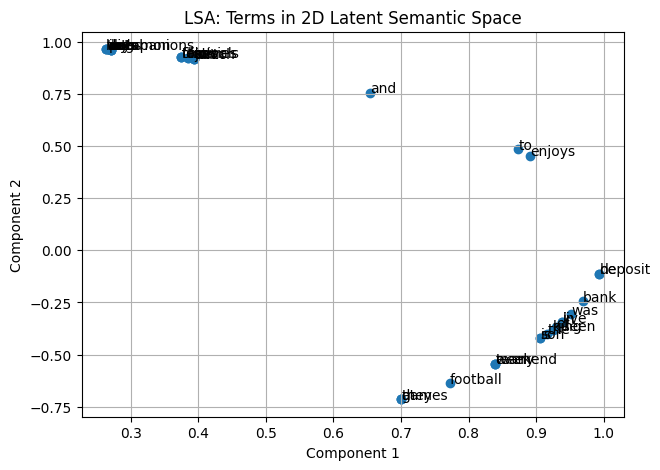

Explained variance (2 comps): 0.20710667783488956


In [9]:

# fit LSA with 2 components for easy plotting
svd = TruncatedSVD(n_components=2, random_state=42)
X_lsa = svd.fit_transform(X_tfidf)          # docs in latent space
terms_lsa = svd.components_.T               # terms mapped to latent space

# normalize term vectors for nicer spacing
terms_lsa_norm = normalize(terms_lsa)

# oick a subset of terms to label (frequent ones)
term_freq = X_bow.toarray().sum(axis=0)
top_term_idx = term_freq.argsort()[::-1][:40]
labels = [vocab_tfidf[i] for i in top_term_idx]
pts = terms_lsa_norm[top_term_idx]

# scatter plot of terms in 2D
plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])
for (x, y), lab in zip(pts, labels):
    plt.text(x, y, lab)
plt.title("LSA: Terms in 2D Latent Semantic Space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

print("Explained variance (2 comps):", svd.explained_variance_ratio_.sum())

## 4. Word2Vec

**Core idea**: Train a tiny NN (CBOW/Skip-gram) to predict words from context (or vice versa); vectors are embeddings.

**Why it matters**: Efficiently learned dense semantic vectors with linear analogies (e.g., king−man+woman≈queen).

**Strengths**: Captures global semantics; compact; transferable; fast to train.

**Limits**: Static (one vector per word); no token-level context; OOV unless handled.

**Use cases**: Similarity, clustering, as features in classic/deep pipelines


In [10]:
w2v = api.load('word2vec-google-news-300')

    # Inspect neighbors
probe_words = ["journey", "castle", "coffin", "blood", "bat", "maiden", "count"]
for w in probe_words:
  if w in w2v.wv:
    print(f"Most similar to '{w}':", w2v.wv.most_similar(w, topn=5))

    # Visualize a subset of word vectors in 2D via PCA
    subset = [w for w in probe_words if w in w2v.wv]
    vecs = np.array([w2v.wv[w] for w in subset])
    pca = PCA(n_components=2, random_state=42)
    xy = pca.fit_transform(vecs)

    plt.figure()
    plt.scatter(xy[:, 0], xy[:, 1])
    for (x, y), lab in zip(xy, subset):
        plt.text(x, y, lab)
    plt.title("Word2Vec: PCA Projection of Selected Words")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

[==============================--------------------] 61.9% 1030.0/1662.8MB downloaded

ContentTooShortError: <urlopen error retrieval incomplete: got only 1080033280 out of 1743563840 bytes>


## 6. GloVe (Global Vectors)


In [ ]:

import gensim.downloader as api
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

glove_pre = api.load("glove-wiki-gigaword-100")

#nearest neighbors
passrobe_words = ["king", "queen", "paris", "france", "italy", "rome", "football", "movie", "cat", "dog"]
for w in probe_words:
  if w in glove_pre.key_to_index:
    print(f"Nearest to '{w}':", glove_pre.most_similar(w, topn=5))

    # analogies
  def analogy(pos, neg, topn=5):
    return glove_pre.most_similar(positive=pos, negative=neg, topn=topn)

    print("\nAnalogy: king - man + woman  ->", analogy(['king','woman'], ['man'], 5))
    print("Analogy: paris - france + italy ->", analogy(['paris','italy'], ['france'], 5))

    # PCA visualization
    subset = ["king","queen","man","woman","paris","france","rome","italy","cat","dog","pet"]
    have = [w for w in subset if w in glove_pre.key_to_index]
    vecs = np.array([glove_pre[w] for w in have])
    xy = PCA(n_components=2, random_state=42).fit_transform(vecs)





Nearest to 'king': [('prince', 0.7682328820228577), ('queen', 0.7507690787315369), ('son', 0.7020888328552246), ('brother', 0.6985775232315063), ('monarch', 0.6977890729904175)]
Nearest to 'queen': [('princess', 0.7947245240211487), ('king', 0.7507690191268921), ('elizabeth', 0.7355712056159973), ('royal', 0.7065026164054871), ('lady', 0.7044796943664551)]
Nearest to 'cats': [('dogs', 0.7869132161140442), ('rabbits', 0.7540634870529175), ('animals', 0.7538943290710449), ('pets', 0.749773383140564), ('cat', 0.7323004007339478)]
Nearest to 'dogs': [('dog', 0.834430992603302), ('cats', 0.786913275718689), ('animals', 0.7566978931427002), ('pets', 0.717490017414093), ('cat', 0.7163873314857483)]
Nearest to 'bank': [('banks', 0.8057132959365845), ('banking', 0.7530707120895386), ('credit', 0.7037603259086609), ('investment', 0.6939943432807922), ('financial', 0.6777413487434387)]
Nearest to 'money': [('funds', 0.8508071303367615), ('cash', 0.848483681678772), ('fund', 0.7594833374023438), (

# 7. ELMo
Core idea: Contextual embeddings from a deep bi-LSTM language model; token vectors depend on full sentence.

Why it matters: Solved polysemy at the representation level (different vectors for “bank” in river vs finance).

Strengths: big gains across tasks, character-aware

Limits: less scalable than attention for long sequences.

Use cases: Token-level tasks (NER, QA, coref) when transformers aren’t available


In [ ]:
sent1 = "He went to the bank to deposit money ."
sent2 = "The bank of the river was steep and rocky ."

try:
    from allennlp.commands.elmo import ElmoEmbedder
    elmo = ElmoEmbedder()

    # Returns an array [layers, timesteps, dim]
    e1 = elmo.embed_sentence(sent1.split())
    e2 = elmo.embed_sentence(sent2.split())

    # We'll use the top layer ([-1]) for comparison, average across layers if desired
    # Find index of 'bank' in each sentence
    idx1 = sent1.split().index("bank")
    idx2 = sent2.split().index("bank")

    v1 = e1[-1][idx1].reshape(1, -1)
    v2 = e2[-1][idx2].reshape(1, -1)

    # cosine between the two 'bank' vectors
    cos_bank_bank = float(cosine_similarity(v1, v2)[0,0])
    print("Cosine(bank_money_context, bank_river_context) =", round(cos_bank_bank, 3))

    # Visualize the two vectors relative to their sentence words via PCA
    words1 = sent1.split()
    words2 = sent2.split()
    all_vectors = [e1[-1][i] for i in range(len(words1))] + [e2[-1][i] for i in range(len(words2))]
    xy = PCA(n_components=2, random_state=42).fit_transform(np.array(all_vectors))

    # Split back for plotting
    xy1 = xy[:len(words1)]
    xy2 = xy[len(words1):]

    plt.figure()
    plt.scatter(xy1[:,0], xy1[:,1])
    for (x,y), lab in zip(xy1, words1):
        plt.text(x, y, lab)
    plt.title("ELMo PCA — Sentence 1")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

    plt.figure()
    plt.scatter(xy2[:,0], xy2[:,1])
    for (x,y), lab in zip(xy2, words2):
        plt.text(x, y, lab)
    plt.title("ELMo PCA — Sentence 2")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

except ImportError:
    print("allennlp mssing")
except Exception as e:
    print(f"An error occurred: {e}")

allennlp mssing



## summary

- **BoW / TF–IDF / N-grams:** surface-level counts (simple & strong baselines).
- **LSA:** linear algebra uncovers latent semantics from counts.
- **Word2Vec / GloVe:** dense, learned **static** embeddings with meaningful geometry.
- **ELMo / BERT:** **contextual** embeddings — the same word can mean different things, and the vector reflects that.

**Next steps:**
- Swap in your corpus (or part of it) and check for  patterns.
- Try **FastText**
